<a href="https://colab.research.google.com/github/Sreecharan2027/Transformer-Based-Video-Quality-Prediction/blob/main/Transformer_Based_Video_Quality_Prediction_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount the google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install opencv-python

In [ ]:
import os, cv2, time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
import torch
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import TimesformerForVideoClassification

In [ ]:
"""
## 2. Configuration
"""

# %%
class Config:
    # Paths
    DATA_PATH = r"/content/drive/MyDrive/IITHPROJECT/konvid1k/videos"
    EXTRACTED_FRAMES_DIR = "/content/drive/MyDrive/IITHPROJECT/extracted_frames"
    OUTPUT_DIR = "output"
    LABELS_CSV_PATH = r"/content/drive/MyDrive/IITHPROJECT/konvid1k/konvid1k_metadata.csv"

    # Frame extraction
    FRAME_EXTRACTION_METHOD = "uniform"  # "uniform", "random", or "all"
    FRAME_EXTRACTION_RATE = 5  # Extract every nth frame
    MAX_FRAMES_TO_EXTRACT = 100  # Max frames per video

    # Model
    MODEL_NAME = "facebook/timesformer-base-finetuned-k400"
    INPUT_SIZE = 224
    NUM_FRAMES = 8  # Number of frames to use per video

    # Training
    BATCH_SIZE = 1
    EPOCHS = 15
    LEARNING_RATE = 1e-4
    TEST_SIZE = 0.2

    # Device
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create directories
#os.makedirs(Config.EXTRACTED_FRAMES_DIR, exist_ok=True)
#os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [ ]:

def extract_frames(video_path, output_dir, method="uniform", rate=5, max_frames=100):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = total_frames / fps if fps else 0

    print(f"\n🎞️  {os.path.basename(video_path)} — {total_frames} frames | {duration:.2f}s")

    if method == "all":
        frame_indices = list(range(min(total_frames, max_frames)))
    elif method == "uniform":
        step = max(1, total_frames // min(max_frames, total_frames))
        frame_indices = list(range(0, total_frames, step))[:max_frames]
    elif method == "random":
        frame_indices = sorted(np.random.choice(total_frames, min(max_frames, total_frames), replace=False))
    else:
        frame_indices = []

    extracted_count = 0
    start_time = time.time()
    executor = ThreadPoolExecutor()

    current_index = 0
    for i in tqdm(frame_indices, desc="Progress", unit="frame"):
        if method == "uniform":
            while current_index < i:
                cap.read()
                current_index += 1
            ret, frame = cap.read()
            current_index += 1
        else:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (Config.INPUT_SIZE, Config.INPUT_SIZE))
            frame_path = os.path.join(output_dir, f"frame_{i:06d}.jpg")
            executor.submit(Image.fromarray(frame).save, frame_path)
            extracted_count += 1

    cap.release()
    executor.shutdown(wait=True)
    elapsed = time.time() - start_time

    print(f"✅ {extracted_count} frames extracted in {elapsed:.2f}s ({extracted_count/elapsed:.2f} fps)")

    return {
        "video_file": os.path.basename(video_path),
        "total_frames": total_frames,
        "extracted_frames": extracted_count,
        "time_elapsed": elapsed,
        "output_dir": output_dir
    }


def extract_all_videos():
    video_files = [f for f in os.listdir(Config.DATA_PATH) if f.endswith('.mp4')]
    total_videos = len(video_files)
    extraction_log = []

    print(f"\n🚀 Extracting from {total_videos} videos")

    for video_file in tqdm(video_files, desc="Videos", unit="video"):
        video_path = os.path.join(Config.DATA_PATH, video_file)
        output_dir = os.path.join(Config.EXTRACTED_FRAMES_DIR, os.path.splitext(video_file)[0])

        result = extract_frames(
            video_path, output_dir,
            method=Config.FRAME_EXTRACTION_METHOD,
            rate=Config.FRAME_EXTRACTION_RATE,
            max_frames=Config.MAX_FRAMES_TO_EXTRACT
        )
        extraction_log.append(result)

    df = pd.DataFrame(extraction_log)
    log_path = os.path.join(Config.EXTRACTED_FRAMES_DIR, "extraction_log.csv")
    df.to_csv(log_path, index=False)

    print(f"\n📄 Log saved to: {log_path}")
    return df

#df_log = extract_all_videos()
#df_log.head()


In [ ]:
import os
import pandas as pd
from PIL import Image

# Load the CSV file
log_path = r"/content/drive/MyDrive/IITHPROJECT/extracted_frames/extraction_log.csv"
df_log = pd.read_csv(log_path)

# Define the summary function
def print_data_summary(df_log):
    total_videos = df_log.shape[0]
    total_frames = df_log["extracted_frames"].sum()

    # Try to read a sample frame to get image dimensions
    sample_folder = df_log["output_dir"].iloc[0]
    sample_frame_path = sorted(os.listdir(sample_folder))[0]
    sample_image = Image.open(os.path.join(sample_folder, sample_frame_path))
    width, height = sample_image.size
    image_mode = sample_image.mode
    channels = len(sample_image.getbands())

    print("\n📊 DATA SUMMARY")
    print(f"🎬 Total Videos: {total_videos}")
    print(f"🖼️  Total Frames Extracted: {total_frames}")
    print(f"📐 Image Size: {width}x{height} pixels")
    print(f"🧾 Frame Size (Width x Height): {width} x {height}")
    print(f"📦 Data Dimension: ({total_frames}, {height}, {width}, {channels})")
    print(f"🎨 Image Mode: {image_mode}")

# Call the function
print_data_summary(df_log)



📊 DATA SUMMARY
🎬 Total Videos: 1200
🖼️  Total Frames Extracted: 120000
📐 Image Size: 224x224 pixels
🧾 Frame Size (Width x Height): 224 x 224
📦 Data Dimension: (120000, 224, 224, 3)
🎨 Image Mode: RGB


In [ ]:
'''import os
#EXTRACTED_FRAMES_DIR = "data\extracted_frames"
def validate_extracted_frames(video_files, extracted_frames_dir):
    missing_dirs = []
    empty_dirs = []

    for video_file in video_files:
        video_name = os.path.splitext(video_file)[0]
        frame_dir = os.path.join(extracted_frames_dir, video_name)

        if not os.path.exists(frame_dir):
            missing_dirs.append(frame_dir)
        elif len([f for f in os.listdir(frame_dir) if f.endswith('.jpg')]) == 0:
            empty_dirs.append(frame_dir)

    return missing_dirs, empty_dirs

# Run this right after loading video files
video_files = [f for f in os.listdir(Config.DATA_PATH) if f.endswith('.mp4')]
missing, empty = validate_extracted_frames(video_files, Config.EXTRACTED_FRAMES_DIR)

print(f"Missing frame dirs: {len(missing)}")
for path in missing:
    print("❌", path)

print(f"Empty frame dirs: {len(empty)}")
for path in empty:
    print("⚠️", path)'''


In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split

# %%
def get_transforms():
    """Get image transformations"""
    return transforms.Compose([
        transforms.Resize((Config.INPUT_SIZE, Config.INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# %%
class VideoQualityDataset(Dataset):
    def __init__(self, video_files, labels, transform=None):
        self.video_files = video_files
        self.labels = labels
        self.transform = transform or get_transforms()

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_name = os.path.splitext(self.video_files[idx])[0]
        frame_dir = os.path.join(Config.EXTRACTED_FRAMES_DIR, video_name)

        frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])
        frame_files = self._select_frames(frame_files)

        frames = []
        for frame_file in frame_files:
            frame_path = os.path.join(frame_dir, frame_file)
            frame = Image.open(frame_path).convert("RGB")
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        frames = torch.stack(frames)  # Shape: (T, C, H, W)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return frames, label

    def _select_frames(self, frame_files):
        if Config.FRAME_EXTRACTION_METHOD == "random":
            step = 1
        else:
            step = max(1, len(frame_files) // Config.NUM_FRAMES)

        return frame_files[::step][:Config.NUM_FRAMES]

# %%
def prepare_datasets():
    """Prepare train and test datasets using MOS labels from CSV"""
    # Load the CSV
    df = pd.read_csv(Config.LABELS_CSV_PATH)  # e.g. 'konvid_labels.csv'

    # Create full video filenames from flickr_id
    df['filename'] = df['flickr_id'].astype(str) + '.mp4'

    # Filter videos that exist in the dataset folder
    all_videos = set(os.listdir(Config.DATA_PATH))
    df = df[df['filename'].isin(all_videos)]

    video_files = df['filename'].tolist()
    labels = df['mos'].values

    # Split into train and test
    train_files, test_files, train_labels, test_labels = train_test_split(
        video_files, labels, test_size=Config.TEST_SIZE, random_state=42
    )

    # Create datasets and dataloaders
    transform = get_transforms()
    train_dataset = VideoQualityDataset(train_files, train_labels, transform)
    test_dataset = VideoQualityDataset(test_files, test_labels, transform)

    print(f"✅ Total videos: {len(video_files)}")
    print(f"🟢 Training set size: {len(train_dataset)}")
    print(f"🔵 Test set size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, test_loader


# %%
train_loader, test_loader = prepare_datasets()

for batch in train_loader:
    frames, labels = batch
    print("Frames shape:", frames.shape)  # Expected: (B, T, C, H, W)
    print("Labels shape:", labels.shape)  # Expected: (B,)
    break


✅ Total videos: 1200
🟢 Training set size: 960
🔵 Test set size: 240
Frames shape: torch.Size([1, 8, 3, 224, 224])
Labels shape: torch.Size([1])


In [ ]:
class VideoQualityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TimesformerForVideoClassification.from_pretrained(
            Config.MODEL_NAME,
            num_frames=Config.NUM_FRAMES,
            ignore_mismatched_sizes=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        outputs = self.base_model.timesformer(pixel_values=x)
        last_hidden_state = outputs.last_hidden_state  # (B, N_tokens, D)

        # Option 1: Mean pooling (what you're currently doing)
        #last_hidden_state = last_hidden_state.mean(dim=1)  # (B, D)
        #pooled_output = last_hidden_state
        # Option 2 (alternative): Use CLS token only
        last_hidden_state = last_hidden_state[:, 0, :]
        cls_token = last_hidden_state
        #print("Pooled shape:", pooled_output.shape)
        return self.classifier(cls_token).squeeze(), last_hidden_state


In [ ]:
print("Model Architecture:")
print(VideoQualityModel())

Model Architecture:


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


VideoQualityModel(
  (base_model): TimesformerForVideoClassification(
    (timesformer): TimesformerModel(
      (embeddings): TimesformerEmbeddings(
        (patch_embeddings): TimesformerPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (pos_drop): Dropout(p=0.0, inplace=False)
        (time_drop): Dropout(p=0.0, inplace=False)
      )
      (encoder): TimesformerEncoder(
        (layer): ModuleList(
          (0-11): 12 x TimesformerLayer(
            (drop_path): Identity()
            (attention): TimeSformerAttention(
              (attention): TimesformerSelfAttention(
                (qkv): Linear(in_features=768, out_features=2304, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
              )
              (output): TimesformerSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
    

In [ ]:
pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 791.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
from torchviz import make_dot

# 👇 Set your device: CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = VideoQualityModel().to(device)

# Generate a dummy input (shape: batch_size x channels x frames x height x width)
# For TimeSformer: usually (B, C, T, H, W) → e.g., (1, 3, 8, 224, 224)
x = torch.randn(1, 8, 3, 224, 224).to(device)  # B, T, C, H, W


# Pass input through model
out = model(x)

# 🔧 Create graph
dot = make_dot(out, params=dict(model.named_parameters()))
dot.format = 'png'

# 💾 Save to file
dot.render('video_quality_model_architecture')

print("✅ Model architecture saved as 'video_quality_model_architecture.png'")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.554997 to fit


✅ Model architecture saved as 'video_quality_model_architecture.png'


In [ ]:
def inspect_model_parameters():
    model = VideoQualityModel().to(Config.DEVICE)

    total_params = 0
    trainable_params = 0

    #print("\n🧠 Model Parameter Overview:")
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        #print(f"{name:<60} shape={str(param.shape):<20} trainable={param.requires_grad}")

    print("\n📊 Summary:")
    print(f"🔢 Total parameters: {total_params:,}")
    print(f"✅ Trainable parameters: {trainable_params:,}")
    print(f"❎ Non-trainable parameters: {total_params - trainable_params:,}")
inspect_model_parameters()



📊 Summary:
🔢 Total parameters: 121,763,473
✅ Trainable parameters: 121,763,473
❎ Non-trainable parameters: 0


In [ ]:
def train_model():
    # Initialize
    train_loader, test_loader = prepare_datasets()
    model = VideoQualityModel().to(Config.DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.MSELoss()

    # Training history
    history = {'train_loss': [], 'test_loss': []}

    # 🧪 DEBUG: Run one batch before training starts
    model.eval()
    with torch.no_grad():
        for frames, labels in train_loader:
            frames, labels = frames.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs, base_model_output = model(frames)
            outputs = outputs.view(-1)
            labels = labels.view(-1)

            print("\n📊 DEBUG INFO BEFORE TRAINING STARTS")
            print(outputs.shape)                            # torch.Size([1])
            print(outputs)                                  # tensor([...])
            print("Base output shape:", base_model_output.shape)  # torch.Size([1, 768])
            print("Num frames:", Config.NUM_FRAMES)               # 8
            print("Expected patches per frame:", (base_model_output.shape[1] - 1) // Config.NUM_FRAMES)
            print(labels.shape, labels)                     # torch.Size([1]), tensor([...])
            print("--------------------------------------------------\n")
            break  # Only print for the first batch

    # 🔁 Training loop
    for epoch in range(Config.EPOCHS):
        model.train()
        train_loss = 0.0

        for frames, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}"):
            frames, labels = frames.to(Config.DEVICE), labels.to(Config.DEVICE)

            optimizer.zero_grad()
            outputs, base_model_output = model(frames)
            #outputs = outputs.view(-1)
            #labels = labels.view(-1)
            outputs = outputs.view(-1)
            labels = labels.view_as(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for frames, labels in test_loader:
                frames, labels = frames.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(frames)[0]

                outputs = outputs.view(-1)
                labels = labels.view_as(outputs)

                test_loss += criterion(outputs, labels).item()

                avg_test_loss = test_loss / len(test_loader)
                history['test_loss'].append(avg_test_loss)

        print(f"✅ Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    # 💾 Save model
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(Config.OUTPUT_DIR, "vqa_model1.pth"))
    return model, history

# 🚀 Start training
model, history = train_model()


✅ Total videos: 1200
🟢 Training set size: 960
🔵 Test set size: 240

📊 DEBUG INFO BEFORE TRAINING STARTS
torch.Size([1])
tensor([-0.0981], device='cuda:0')
Base output shape: torch.Size([1, 768])
Num frames: 8
Expected patches per frame: 95
torch.Size([1]) tensor([3.0400], device='cuda:0')
--------------------------------------------------



Epoch 1/15: 100%|██████████| 960/960 [08:15<00:00,  1.94it/s]


✅ Epoch 1: Train Loss: 0.4425, Test Loss: 0.2476


Epoch 2/15: 100%|██████████| 960/960 [08:21<00:00,  1.91it/s]


✅ Epoch 2: Train Loss: 0.2992, Test Loss: 0.2469


Epoch 3/15: 100%|██████████| 960/960 [08:10<00:00,  1.96it/s]


✅ Epoch 3: Train Loss: 0.2755, Test Loss: 0.2037


Epoch 4/15: 100%|██████████| 960/960 [08:13<00:00,  1.94it/s]


✅ Epoch 4: Train Loss: 0.2183, Test Loss: 0.2776


Epoch 5/15: 100%|██████████| 960/960 [08:13<00:00,  1.95it/s]


✅ Epoch 5: Train Loss: 0.2153, Test Loss: 0.2949


Epoch 6/15: 100%|██████████| 960/960 [08:13<00:00,  1.94it/s]


✅ Epoch 6: Train Loss: 0.1692, Test Loss: 0.2008


Epoch 7/15: 100%|██████████| 960/960 [08:13<00:00,  1.94it/s]


✅ Epoch 7: Train Loss: 0.1406, Test Loss: 0.2311


Epoch 8/15: 100%|██████████| 960/960 [08:13<00:00,  1.95it/s]


✅ Epoch 8: Train Loss: 0.1260, Test Loss: 0.1993


Epoch 9/15: 100%|██████████| 960/960 [08:12<00:00,  1.95it/s]


✅ Epoch 9: Train Loss: 0.1112, Test Loss: 0.2310


Epoch 10/15: 100%|██████████| 960/960 [08:14<00:00,  1.94it/s]


✅ Epoch 10: Train Loss: 0.1103, Test Loss: 0.3028


Epoch 11/15: 100%|██████████| 960/960 [08:11<00:00,  1.95it/s]


✅ Epoch 11: Train Loss: 0.0861, Test Loss: 0.2240


Epoch 12/15: 100%|██████████| 960/960 [08:11<00:00,  1.95it/s]


✅ Epoch 12: Train Loss: 0.0903, Test Loss: 0.2125


Epoch 13/15: 100%|██████████| 960/960 [08:11<00:00,  1.95it/s]


✅ Epoch 13: Train Loss: 0.1016, Test Loss: 0.2016


Epoch 14/15: 100%|██████████| 960/960 [08:13<00:00,  1.95it/s]


✅ Epoch 14: Train Loss: 0.0751, Test Loss: 0.2193


Epoch 15/15: 100%|██████████| 960/960 [08:11<00:00,  1.95it/s]


✅ Epoch 15: Train Loss: 0.0771, Test Loss: 0.2295


In [ ]:
model_output_dir = "/content/drive/MyDrive/IITHPROJECT/models"
os.makedirs(model_output_dir, exist_ok=True)

In [ ]:
model = VideoQualityModel().to(Config.DEVICE)


In [ ]:
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(Config.OUTPUT_DIR, "vqa_model1.pth"))

In [ ]:
'''history = {
    'train_loss': [0.4384, 0.2917, 0.2660, 0.2351, 0.2014, 0.1913, 0.1341, 0.1259],
    'test_loss':  [0.2011, 0.2192, 0.1856, 0.3123, 0.2341, 0.2856, 0.2476, 0.2266]
}
'''

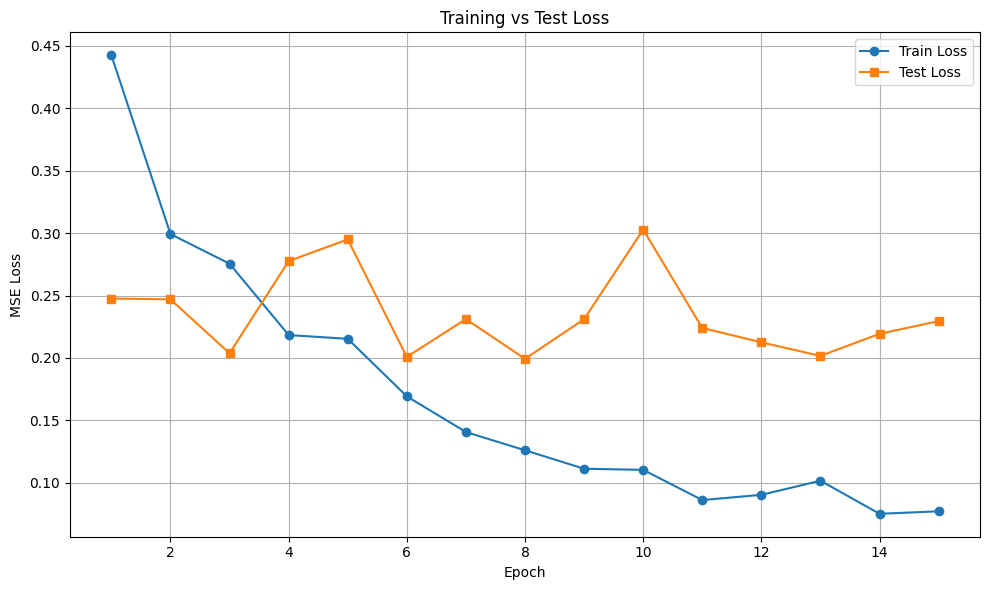

In [ ]:
import matplotlib.pyplot as plt

# Loss values from your log
train_loss = [0.4425, 0.2992, 0.2755, 0.2183, 0.2153, 0.1692, 0.1406, 0.1260, 0.1112, 0.1103, 0.0861, 0.0903, 0.1016, 0.0751, 0.0771]
test_loss =  [0.2476, 0.2469, 0.2037, 0.2776, 0.2949, 0.2008, 0.2311, 0.1993, 0.2310, 0.3028, 0.2240, 0.2125, 0.2016, 0.2193, 0.2295]

epochs = range(1, 16)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, test_loss, label="Test Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


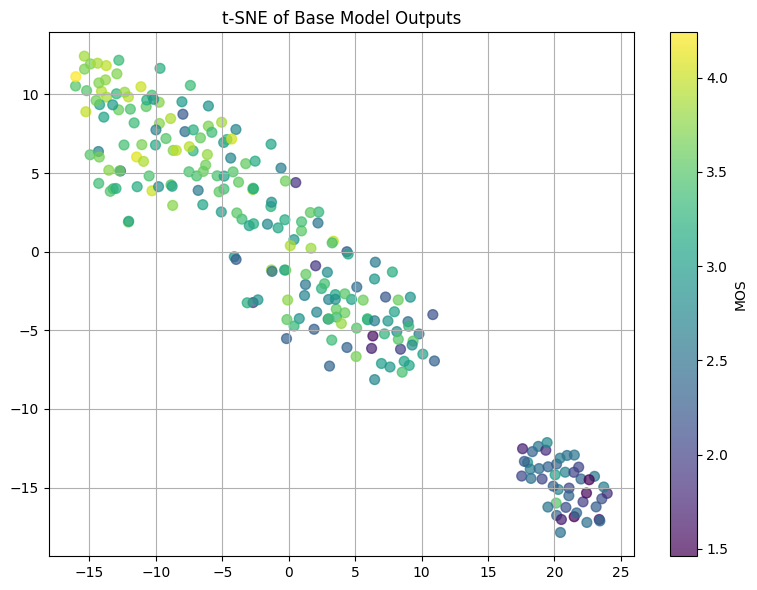

In [ ]:
from sklearn.manifold import TSNE

def generate_tsne(model, test_loader):
    model.eval()
    base_outputs, labels = [], []

    with torch.no_grad():
        for frames, lbls in test_loader:
            frames = frames.to(Config.DEVICE)
            _, base_out = model(frames)
            base_outputs.append(base_out.cpu())
            labels.extend(lbls.cpu().numpy())

    base_outputs = torch.cat(base_outputs).numpy()
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(base_outputs)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar(scatter, label="MOS")
    plt.title("t-SNE of Base Model Outputs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

generate_tsne(model, test_loader)


In [ ]:
import torch
import torch.nn as nn
from transformers import TimesformerForVideoClassification
from PIL import Image
import os

# --- Your custom VideoQualityModel ---
class VideoQualityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = TimesformerForVideoClassification.from_pretrained(
            Config.MODEL_NAME,
            num_frames=Config.NUM_FRAMES,
            ignore_mismatched_sizes=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        outputs = self.base_model.timesformer(pixel_values=x)
        last_hidden_state = outputs.last_hidden_state  # (B, N_tokens, D)
        cls_token = last_hidden_state[:, 0, :]
        return self.classifier(cls_token).squeeze(), cls_token

# --- Load the model ---
model = VideoQualityModel()
model.load_state_dict(torch.load("/content/drive/MyDrive/IITHPROJECT/vqa_model15ep.pth", map_location=Config.DEVICE))
model = model.to(Config.DEVICE)

# --- Inference function ---
def predict_video_quality(video_path, model):
    """Predict quality score for a single video"""
    temp_dir = "temp_frames"

    extract_frames(
        video_path, temp_dir,
        method=Config.FRAME_EXTRACTION_METHOD,
        rate=Config.FRAME_EXTRACTION_RATE,
        max_frames=Config.NUM_FRAMES
    )

    transform = get_transforms()
    frame_files = sorted([f for f in os.listdir(temp_dir) if f.endswith('.jpg')])[:Config.NUM_FRAMES]
    frames = [transform(Image.open(os.path.join(temp_dir, f))) for f in frame_files]

    # Clean up
    for f in frame_files:
        os.remove(os.path.join(temp_dir, f))
    os.rmdir(temp_dir)

    frames = torch.stack(frames).unsqueeze(0).to(Config.DEVICE)  # (1, T, C, H, W)

    model.eval()
    with torch.no_grad():
        score, _ = model(frames)  # Only use the score
        score = score.item()
        scaled_score = max(0, min(score, 5))
    return scaled_score

# --- Example usage ---
video_path = "/content/drive/MyDrive/IITHPROJECT/konvid1k/videos/10116604143.mp4"
quality_score = predict_video_quality(video_path, model)
print(f"🎥 Predicted quality score: {quality_score:.2f}")



🎞️  10116604143.mp4 — 192 frames | 8.01s


Progress: 100%|██████████| 8/8 [00:01<00:00,  7.98frame/s]


✅ 8 frames extracted in 1.02s (7.84 fps)
🎥 Predicted quality score: 2.50


In [ ]:
from tqdm import tqdm

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="🔍 Evaluating"):
            frames, labels = batch
            frames = frames.to(device)  # (B, T, C, H, W)
            labels = labels.to(device)

            preds, _ = model(frames)
            preds = preds.flatten()  # Keeps shape consistent for all batch sizes

            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(ground_truths)


In [ ]:
preds, trues = evaluate_model(model, test_loader, Config.DEVICE)

# Print a few results
for i in range(240):
    print(f"🎥 Sample {i+1}: True MOS = {trues[i]:.2f}, Predicted = {max(0, min(preds[i], 5)):.2f}")


🔍 Evaluating: 100%|██████████| 240/240 [38:30<00:00,  9.63s/it]

🎥 Sample 1: True MOS = 1.62, Predicted = 1.68
🎥 Sample 2: True MOS = 2.64, Predicted = 3.30
🎥 Sample 3: True MOS = 3.84, Predicted = 4.12
🎥 Sample 4: True MOS = 3.34, Predicted = 3.57
🎥 Sample 5: True MOS = 3.94, Predicted = 3.71
🎥 Sample 6: True MOS = 1.98, Predicted = 2.62
🎥 Sample 7: True MOS = 3.49, Predicted = 2.18
🎥 Sample 8: True MOS = 2.40, Predicted = 1.94
🎥 Sample 9: True MOS = 3.38, Predicted = 3.44
🎥 Sample 10: True MOS = 2.66, Predicted = 3.77
🎥 Sample 11: True MOS = 2.74, Predicted = 3.34
🎥 Sample 12: True MOS = 4.02, Predicted = 3.70
🎥 Sample 13: True MOS = 3.99, Predicted = 3.24
🎥 Sample 14: True MOS = 2.68, Predicted = 3.05
🎥 Sample 15: True MOS = 3.60, Predicted = 3.06
🎥 Sample 16: True MOS = 3.72, Predicted = 3.60
🎥 Sample 17: True MOS = 3.22, Predicted = 3.12
🎥 Sample 18: True MOS = 2.86, Predicted = 2.44
🎥 Sample 19: True MOS = 2.70, Predicted = 3.12
🎥 Sample 20: True MOS = 3.36, Predicted = 3.60
🎥 Sample 21: True MOS = 3.42, Predicted = 3.65
🎥 Sample 22: True MOS 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(true, pred):
    pred = np.clip(pred, 0, 5)  # Ensure predictions stay in [0, 5]
    print(f"🔎 MSE: {mean_squared_error(true, pred):.4f}")
    print(f"🔎 MAE: {mean_absolute_error(true, pred):.4f}")
    print(f"🔎 R² Score: {r2_score(true, pred):.4f}")

# Evaluate metrics
print_metrics(trues, preds)


🔎 MSE: 0.2295
🔎 MAE: 0.3810
🔎 R² Score: 0.3981


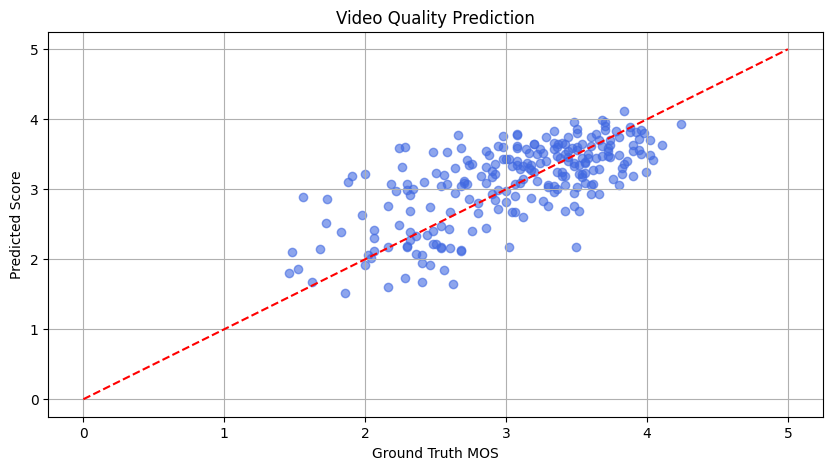

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(trues, preds, alpha=0.6, color='royalblue')
plt.plot([0, 5], [0, 5], 'r--')  # Line of perfect prediction
plt.xlabel("Ground Truth MOS")
plt.ylabel("Predicted Score")
plt.title("Video Quality Prediction")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import numpy as np

# Clamp predictions to valid range
preds_clamped = np.clip(preds, 0, 5)

# PLCC
plcc, _ = pearsonr(trues, preds_clamped)

# SRCC
srcc, _ = spearmanr(trues, preds_clamped)

# RMSE
rmse = np.sqrt(mean_squared_error(trues, preds_clamped))

# 📊 Display results
print(f"\n📈 PLCC:  {plcc:.4f}")
print(f"📊 SRCC:  {srcc:.4f}")
print(f"🔍 RMSE:  {rmse:.4f}")



📈 PLCC:  0.6831
📊 SRCC:  0.6502
🔍 RMSE:  0.4790
